In [58]:
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Desktop/cnn_dev/florence_mapping/utilities.py'>

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="3";

In [4]:
util.class_to_index

{11: 0,
 21: 3,
 22: 1,
 23: 1,
 24: 1,
 31: 4,
 41: 2,
 42: 2,
 43: 2,
 52: 2,
 71: 3,
 81: 3,
 82: 3,
 90: 2,
 95: 5}

In [5]:
def strange_network_v2(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock(input_img, 4, 20)
    pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock(pool_1, 4, 20)
    upsample_1 = TimeDistributed(UpSampling2D((3,3))) (strange_block_2)
    conv_1 = TimeDistributed(Conv2D(32, (3,3)))(upsample_1)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (conv_1)
    reshaping = Reshape((64*64,class_count)) (conv_lc)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), padding = 'same', return_sequences=False, name='canopy')(conv_1)
    model = Model(inputs=input_img, outputs=reshaping)  # conv_out_cc])
    return model

In [6]:
def strangeBlock(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = ConvLSTM2D(filters=filters,kernel_size=(3,3), activation='elu', padding = 'same', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [7]:
def strange_network_v3(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock(input_img, 4, 20)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock(strange_block_1, 4, 20)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (strange_block_2)
    reshaping = Reshape((64*64,class_count)) (conv_lc)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), padding = 'same', return_sequences=False, name='canopy')(conv_1)
    model = Model(inputs=input_img, outputs=reshaping)  # conv_out_cc])
    return model
    

In [8]:
def strange_network_v4(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock(input_img, 4, 20)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock(strange_block_1, 4, 20)
    strange_block_3 = strangeBlock(strange_block_2, 4, 20)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (strange_block_3)
    conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), activation='sigmoid', padding = 'same', return_sequences=False, name='canopy')(strange_block_3)
    model = Model(inputs=input_img, outputs=[conv_lc, conv_out_cc])
    return model

In [37]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

In [38]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [39]:
tile_size = 1
tile_list = ['028012', '029011', '028011']
class_count = 6
epochs = 200
batch_size = 25

In [92]:
#px = rnn_pixels.make_pixels(tile_size, tile_list)

In [276]:
#use_px = px[:1000000]

In [277]:
#pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, use_px, tile_size)

In [12]:
pixels = util.read_txt(['pixels.txt'])
pixels = np.asarray(pixels)
pixels = pixels.reshape(len(pixels[0]), 2)

In [52]:
train_px, val_px, test_px = util.read_txt(['train_px.txt', 'val_px.txt', 'test_px.txt'])
train_px = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, train_px, tile_size)
val_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, val_px, tile_size)
test_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, test_px, tile_size)

In [51]:
train_px

array([[(984, 3718), '028012'],
       [(1293, 3012), '028012'],
       [(2934, 3626), '028011'],
       ...,
       [(4196, 751), '028012'],
       [(2266, 1479), '029011'],
       [(1593, 2127), '028012']], dtype=object)

In [80]:
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        label_b = np.argmax(label_b)#['landcover'])
        buckets[label_b].append(pixels[count])
        total_labels.append(label_b)
        count+=1
total_labels = np.asarray(total_labels)
total_labels = total_labels.reshape(len(total_labels)*tile_size*tile_size)
weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)

In [81]:
count = 0 
for z, j in buckets.items():
    print(len(j))
    count += len(j)
print(count) 

147979
7252
174653
93153
1787
14354
0
0
0
0
0
0
0
439178


In [251]:
use_px = []
use_px+=buckets[0][:3000]
use_px+=(buckets[1][:3000])
use_px+=(buckets[2][:3000])
use_px+=(buckets[3][:3000])
use_px+=(buckets[4][:3000])
use_px+=(buckets[5][:3000])
random.shuffle(use_px)

In [252]:
train_px, val_px, test_px = rnn_pixels.train_val_test_split(use_px, 0.7, 0.7)

train:11750 val:3525 test:2570


In [41]:
#np.savetxt('use_px.txt', use_px, delimiter='', fmt='%s')
#np.savetxt('train_px.txt', train_px, delimiter='', fmt='%s')
#np.savetxt('val_px.txt', val_px, delimiter='', fmt='%s')
#np.savetxt('test_px.txt', test_px, delimiter='', fmt='%s')

In [253]:
len(use_px)

16787

In [15]:
def strangeBlock_v3(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = Bidirectional(LSTM(units=filters, activation='elu', return_sequences=True)) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [16]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [17]:
def make_dense_model_2(in_shape, num_classes):
    input_tensor = Input(shape = in_shape)
    block = strangeBlock_v4(input_tensor, 3, 20)
    block_2 = strangeBlock_v4(block, 5, 12)
    output = LSTM(num_classes,activation='softmax', return_sequences=False) (block_2)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [18]:
def make_dense_model(in_shape, num_classes):
    input_tensor = Input(shape = in_shape)
    block = strangeBlock_v3(input_tensor, 5, 12)
    output = LSTM(num_classes,activation='softmax', return_sequences=False) (block)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [19]:
def make_single_model(in_shape, num_classes):
    input_tensor = Input(shape = in_shape)
    
    dense_1 = Bidirectional(LSTM(32, activation='elu', return_sequences=True)) (input_tensor)
    dense_2 = Bidirectional(LSTM(32, activation='elu', return_sequences=True)) (dense_1)
    dense_3 = Bidirectional(LSTM(32, activation='elu', return_sequences=True)) (dense_2)
    dense_4 = Bidirectional(LSTM(32, activation='elu', return_sequences=True)) (dense_3)
   
    output = LSTM(num_classes,activation='softmax', return_sequences=False) (dense_4)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [20]:
def make_MLT_dense(in_shape, num_classes):
    input_tensor = Input(shape = in_shape)
    
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    block_3 = strangeBlock_v4(block_2, 3, 20)


    landcover = LSTM(num_classes,activation='softmax', return_sequences=False, name='landcover') (block_3)
    canopy = LSTM(1, return_sequences=False, name='canopy') (block_3)
    
    model = Model(inputs=input_tensor, outputs=[landcover, canopy])
    return model

In [63]:
#model = strange_network_v4((4, tile_size, tile_size, 7), class_count)
#model = make_dense_model((4, 7), class_count)
#model = make_dense_model_2((4, 7), class_count)
model = make_MLT_dense((4,7), class_count)

In [64]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [277]:
#filepath ='mlt_dense_merged_2.hdf5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_landcover_acc', verbose=1, save_best_only=True, mode='max')

In [278]:
#callbacks_list = [checkpoint]

In [65]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy', 'canopy':'mse'}, metrics={'landcover':['accuracy'], 'canopy':['mae']}, loss_weights={"landcover":1, "canopy":1})
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                    validation_steps=len(val_px) // batch_size)# callbacks=callbacks_list)# class_weight=weights_list)# callbacks=callbacks_list) #class_weight=weights, callbacks=callbacks_list) 

Epoch 1/200
467/467 [==============================] - 71s 152ms/step - loss: 0.8613 - landcover_loss: 0.8378 - canopy_loss: 0.0236 - landcover_acc: 0.7255 - canopy_mean_absolute_error: 0.0829 - val_loss: 0.6993 - val_landcover_loss: 0.6823 - val_canopy_loss: 0.0169 - val_landcover_acc: 0.7862 - val_canopy_mean_absolute_error: 0.0653
Epoch 2/200
467/467 [==============================] - 57s 122ms/step - loss: 0.6898 - landcover_loss: 0.6724 - canopy_loss: 0.0174 - landcover_acc: 0.7770 - canopy_mean_absolute_error: 0.0696 - val_loss: 0.6221 - val_landcover_loss: 0.6063 - val_canopy_loss: 0.0158 - val_landcover_acc: 0.8075 - val_canopy_mean_absolute_error: 0.0638
Epoch 3/200
467/467 [==============================] - 57s 122ms/step - loss: 0.6555 - landcover_loss: 0.6389 - canopy_loss: 0.0165 - landcover_acc: 0.7880 - canopy_mean_absolute_error: 0.0679 - val_loss: 0.8070 - val_landcover_loss: 0.7808 - val_canopy_loss: 0.0262 - val_landcover_acc: 0.7465 - val_canopy_mean_absolute_error:

KeyboardInterrupt: 

In [283]:
model.load_weights('mlt_dense_merged_2.hdf5')
#model.save('mlt_model.h5')

In [284]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(test_px, batch_size=1, flatten=True, canopy=True), steps=len(test_px) // 1, verbose=1)


2570/2570 [==============================] - 143s 56ms/step


In [285]:
eval_generator = tile_gen.tile_generator(test_px, batch_size=1, flatten=True, canopy=True)

In [286]:
lc_predictions = np.asarray(predictions[0])
canopy_pred = np.asarray(predictions[1])

In [287]:
import matplotlib as plt

In [288]:
lc_predictions = np.argmax(lc_predictions,axis=-1)

In [289]:
lc_lab = np.empty(lc_predictions.shape)
canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1

In [290]:
label_index = lc_lab.reshape(len(test_px)*tile_size*tile_size)
pred_index = lc_predictions.reshape(len(test_px)*tile_size*tile_size)

In [291]:
total = 0
tot = 0

for count in range(len(canopy_pred)):
    if canopy_true[count] != 0:
        total+= np.absolute(canopy_pred[count] - canopy_true[count])
        tot+=1
print(total/tot)

[0.11]


(array([1613.,  175.,  105.,   62.,   61.,   41.,   47.,   41.,   78.,
         347.]),
 array([-0.02,  0.08,  0.18,  0.28,  0.38,  0.48,  0.58,  0.69,  0.79,
         0.89,  0.99], dtype=float32),
 <a list of 10 Patch objects>)

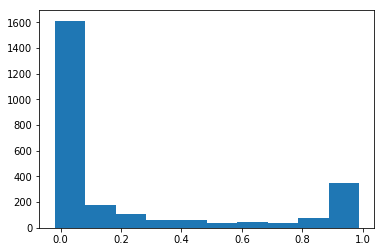

In [292]:
plt.pyplot.hist(canopy_pred)

(array([1642.,   70.,  130.,   84.,   64.,   56.,   41.,   55.,  112.,
         316.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

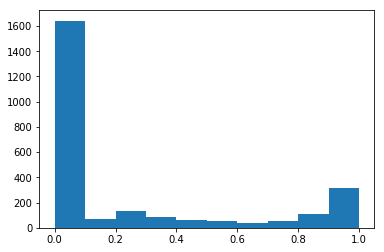

In [293]:
plt.pyplot.hist(canopy_true)

In [294]:
pred_index.shape

(2570,)

In [295]:
np.unique(label_index)

array([0., 1., 2., 3., 4., 5.])

Accuracy is 0.808171206225681


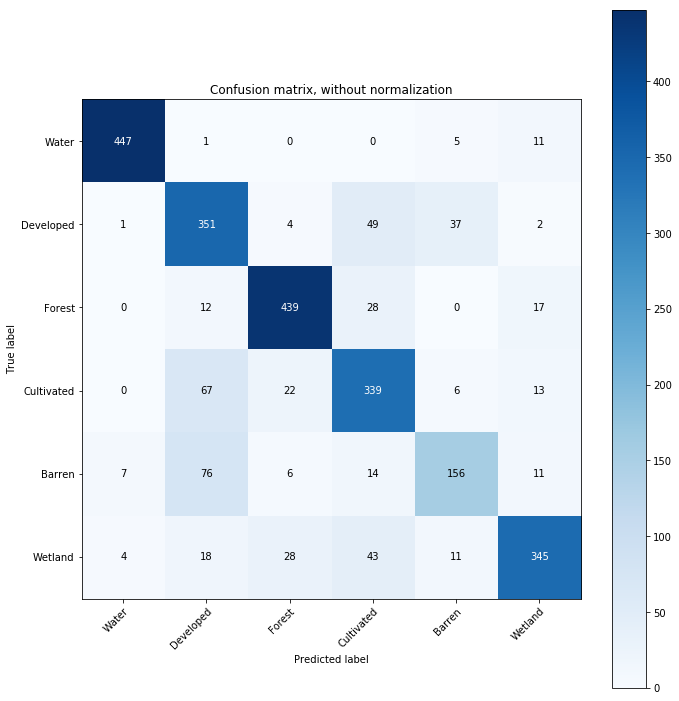

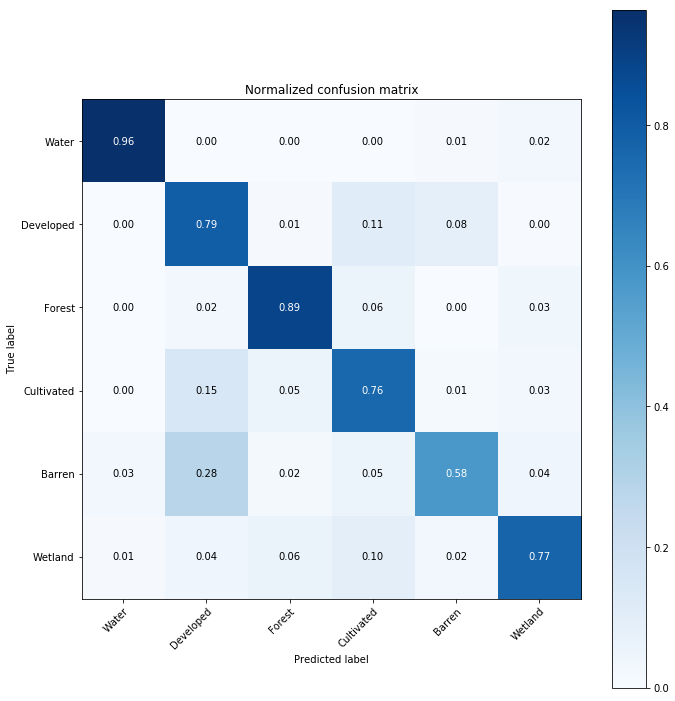

In [296]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True)
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("Accuracy is {}".format(count/len(label_index)))

In [ ]:
from sklearn.utils.multiclass import unique_labels


In [ ]:
def strangeBlock(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = Bidirectional(ConvLSTM2D(filters=filters,kernel_size=(3,3), activation='elu', padding = 'same', return_sequences=True)) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [ ]:
unique_labels(label_index, pred_index)

In [ ]:
def strange_network(input_shape):
    input_img = Input(input_shape)
    #c_l1 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (input_img)
    #c_l2 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (c_l1)
    c_l3 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (input_img)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (c_l3)
    #c_l4 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (pool_1)
    #c_l5 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (c_l4)
    #c_l6 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (pool_1)
    #upsample_1 = TimeDistributed(UpSampling2D((3,3))) (c_l6)
    conv_1 = TimeDistributed(Conv2D(32, (3,3), padding='same'))(c_l3)
    #merge = Concatenate()([c_l3, conv_1])
    conv_lc = ConvLSTM2D(filters=16,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False) (conv_1)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), activation='sigmoid', padding = 'same', return_sequences=False)(merge)
    #model = Model(inputs=input_img, outputs=[conv_lc, conv_out_cc])
    model = Model(inputs=input_img, outputs=conv_lc)
    return model

    


In [332]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth